In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../plotting.mplstyle')

In [2]:
sys.path.insert(0,'../../../scripts')

In [3]:
import reactor_deployment as dep
import scenario_definitions as sd

In [4]:
# read in the LWR deployment data so we can establish a baseline.
lwr_df = pd.read_csv('lwr_info.csv')

# Remove the 'Unnamed: 0' column
lwr_df = lwr_df.drop('Unnamed: 0', axis=1)

In [5]:
lwr_df['retirement_year'] = lwr_df['Actual retirement (year)'].fillna(
    lwr_df['Startup date (year) b'] + 80)

In [6]:
lwr_df

,Reactor name,State,Reactor type,Reactor vendora,Core size (number of assemblies),Startup date (year) b,License expiration (year),Actual retirement (year),power_cap(MWe),retirement_year
0,Arkansas_Nuclear_One_1,AR,PWR,B&W,177,1974,2034,NaN,836.0,2054.0
1,Arkansas_Nuclear_One_2,AR,PWR,CE,177,1978,2038,NaN,988.0,2058.0
2,Beaver_Valley_1,PA,PWR,WE,157,1976,2036,NaN,908.0,2056.0
3,Beaver_Valley_2,PA,PWR,WE,157,1987,2047,NaN,905.0,2067.0
4,Big_Rock_Point,MI,BWR,GE,84,1964,NaN,1997.0,67.0,1997.0
...,...,...,...,...,...,...,...,...,...,...
118,Watts_Bar_2,TN,PWR,WE,193,2016,2055,NaN,1164.0,2096.0
119,Wolf_Creek_1,KS,PWR,WE,193,1985,2045,NaN,1200.0,2065.0
120,Yankee_Rowe,MA,PWR,WE,76,1960,NaN,1991.0,167.0,1991.0
121,Zion_1,IL,PWR,WE,193,1973,NaN,1997.0,1040.0,1997.0


In [7]:
capacity_change = {year: 0 for year in range(sd.sim_start_yr, sd.sim_end_yr)}

# calculate the decommissioned capacity for each retirement year
for year, power in zip(lwr_df['retirement_year'], lwr_df['power_cap(MWe)']):
    capacity_change[int(year)] -= power * sd.lwr_capacity_factor

# calculate the commissioned LWR capacity for each startup year
for year, power in zip(lwr_df['Startup date (year) b'], lwr_df['power_cap(MWe)']):
    capacity_change[int(year)] += power * sd.lwr_capacity_factor

/tmp/ipykernel_9554/3600157219.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])


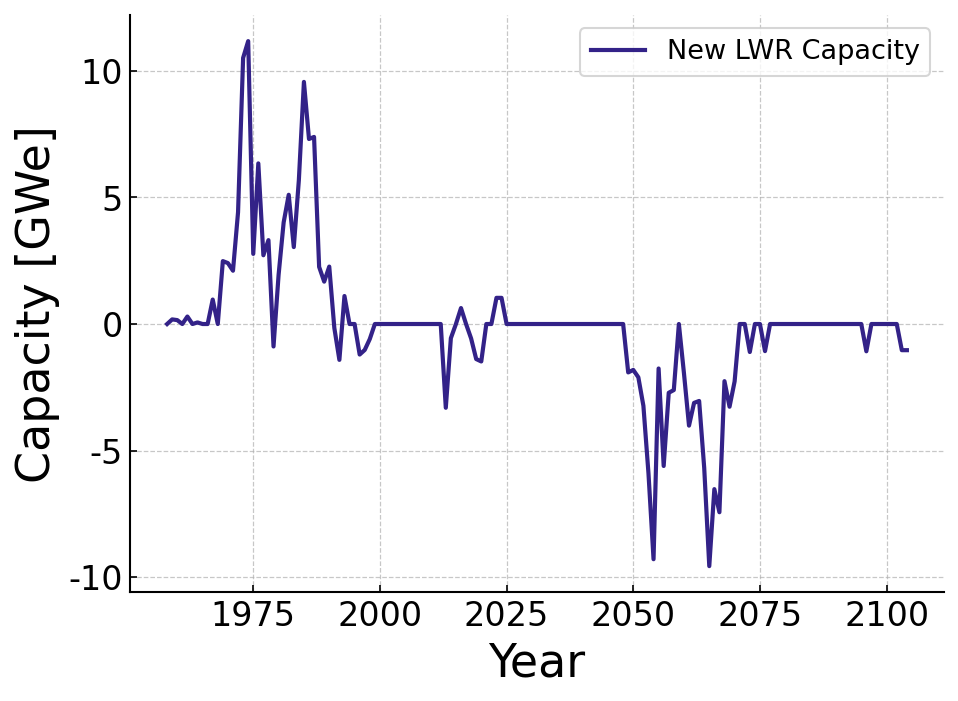

In [8]:
# Convert to a pandas DataFrame and plot.
capacity_change_df = pd.DataFrame(capacity_change.values(), index=capacity_change.keys(), columns=['new_LWR_Capacity'])
capacity_change_df.plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('New LWR Capacity')

In [9]:
# create a total lwr capacity column
capacity_change_df['Total LWR Capacity'] = capacity_change_df['new_LWR_Capacity'].cumsum()

/tmp/ipykernel_9554/722816693.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])


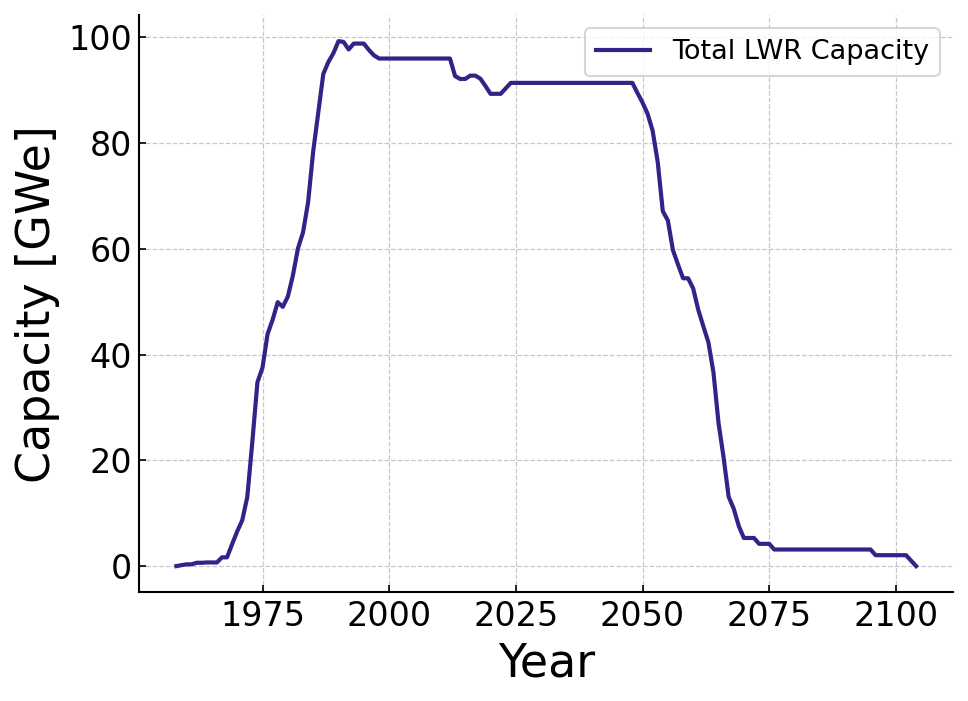

In [10]:
capacity_change_df[["Total LWR Capacity"]].plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('Total LWR Capacity')

In [11]:
# create a time step column that subtracts the start year from the current year and multiplies by 12
capacity_change_df['time_step'] = (capacity_change_df.index - sd.sim_start_yr) * 12

In [12]:
capacity_change_df

,new_LWR_Capacity,Total LWR Capacity,time_step
1958,0.000,0.000000e+00,0
1959,182.225,1.822250e+02,12
1960,154.475,3.367000e+02,24
1961,0.000,3.367000e+02,36
1962,296.000,6.327000e+02,48
...,...,...,...
2100,0.000,2.066450e+03,1704
2101,0.000,2.066450e+03,1716
2102,0.000,2.066450e+03,1728
2103,-1033.225,1.033225e+03,1740


In [13]:
# create a function that will generate the deployinst.xml file for each reactor column by reading in the number of reactors at each time step and converting it into a deployinst.xml file
def generate_deployinst_xml(df, reactor_name, transition_year=sd.transition_year, end_year=sd.sim_end_yr):
  start_row = int(transition_year) + 1
  deployinst_xml = """<DeployInst>
               <prototypes>"""

  for year in range(transition_year, end_year):
    if df.loc[year, f'{reactor}_new'] != 0:
      deployinst_xml += f"""
                  <val>{reactor_name}</val>"""

  deployinst_xml += """
               </prototypes>
               <build_times>"""

  for year in range(transition_year, end_year):
    if df.loc[year, f'{reactor}_new'] != 0:
      deployinst_xml += f"""
                <val>{df.loc[year,'time_step']}</val>"""

  deployinst_xml += """
               </build_times>
               <n_build>"""

  for year in range(transition_year, end_year):
    if df.loc[year, f'{reactor}_new'] != 0:
      deployinst_xml += f"""
                <val>{int(df.loc[year, f'{reactor}_new'])}</val>"""

  deployinst_xml += """
               </n_build>
             </DeployInst>"""

  return deployinst_xml.strip()

# No Growth

In [14]:
base_capacity = capacity_change_df.loc[sd.transition_year, 'Total LWR Capacity'] # in MWe

print(f"Total LWR capacity in {sd.transition_year}: {base_capacity} MWe")

Total LWR capacity in 2029: 91345.60000000002 MWe


In [15]:
no_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=no_growth_cap_df, base_col='Total LWR Capacity', rate=1, start_year=sd.transition_year, end_year=sd.sim_end_yr)

,new_LWR_Capacity,Total LWR Capacity,time_step,Total LWR Capacity Inc 1,New Capacity Inc 1
1958,0.000,0.000000e+00,0,0.000,0.000
1959,182.225,1.822250e+02,12,182.225,0.000
1960,154.475,3.367000e+02,24,336.700,0.000
1961,0.000,3.367000e+02,36,336.700,0.000
1962,296.000,6.327000e+02,48,632.700,0.000
...,...,...,...,...,...
2100,0.000,2.066450e+03,1704,91345.600,89279.150
2101,0.000,2.066450e+03,1716,91345.600,89279.150
2102,0.000,2.066450e+03,1728,91345.600,89279.150
2103,-1033.225,1.033225e+03,1740,91345.600,90312.375


In [16]:
for reactor in sd.ad_reactors.keys():
    no_growth_cap_df[f'{reactor}'] = np.ceil(no_growth_cap_df['New Capacity Inc 1']/sd.ad_reactors[reactor][0])

In [17]:
for reactor in sd.ad_reactors.keys():
    no_growth_cap_df[f'{reactor}_new'] = no_growth_cap_df[f'{reactor}'].diff()

In [18]:
no_growth_cap_df['AP1000_new_cap'] = no_growth_cap_df['AP1000_new'] * sd.ad_reactors['AP1000'][0]
no_growth_cap_df['Xe100_new_cap'] = no_growth_cap_df['Xe100_new'] * sd.ad_reactors['Xe100'][0]
no_growth_cap_df['MMR_new_cap'] = no_growth_cap_df['MMR_new'] * sd.ad_reactors['MMR'][0]

In [19]:
no_growth_cap_df['AP1000_new_cap_total'] = no_growth_cap_df['AP1000_new_cap'].cumsum()
no_growth_cap_df['Xe100_new_cap_total'] = no_growth_cap_df['Xe100_new_cap'].cumsum()
no_growth_cap_df['MMR_new_cap_total'] = no_growth_cap_df['MMR_new_cap'].cumsum()

In [20]:
no_growth_cap_df

,new_LWR_Capacity,Total LWR Capacity,time_step,Total LWR Capacity Inc 1,New Capacity Inc 1,AP1000,Xe100,MMR,AP1000_new,Xe100_new,MMR_new,AP1000_new_cap,Xe100_new_cap,MMR_new_cap,AP1000_new_cap_total,Xe100_new_cap_total,MMR_new_cap_total
1958,0.000,0.000000e+00,0,0.000,0.000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959,182.225,1.822250e+02,12,182.225,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1960,154.475,3.367000e+02,24,336.700,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1961,0.000,3.367000e+02,36,336.700,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1962,296.000,6.327000e+02,48,632.700,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100,0.000,2.066450e+03,1704,91345.600,89279.150,80.0,1116.0,17856.0,0.0,0.0,0.0,0.0,0.0,0.0,89360.0,89280.0,89280.0
2101,0.000,2.066450e+03,1716,91345.600,89279.150,80.0,1116.0,17856.0,0.0,0.0,0.0,0.0,0.0,0.0,89360.0,89280.0,89280.0
2102,0.000,2.066450e+03,1728,91345.600,89279.150,80.0,1116.0,17856.0,0.0,0.0,0.0,0.0,0.0,0.0,89360.0,89280.0,89280.0
2103,-1033.225,1.033225e+03,1740,91345.600,90312.375,81.0,1129.0,18063.0,1.0,13.0,207.0,1117.0,1040.0,1035.0,90477.0,90320.0,90315.0


<Axes: xlabel='time_step'>

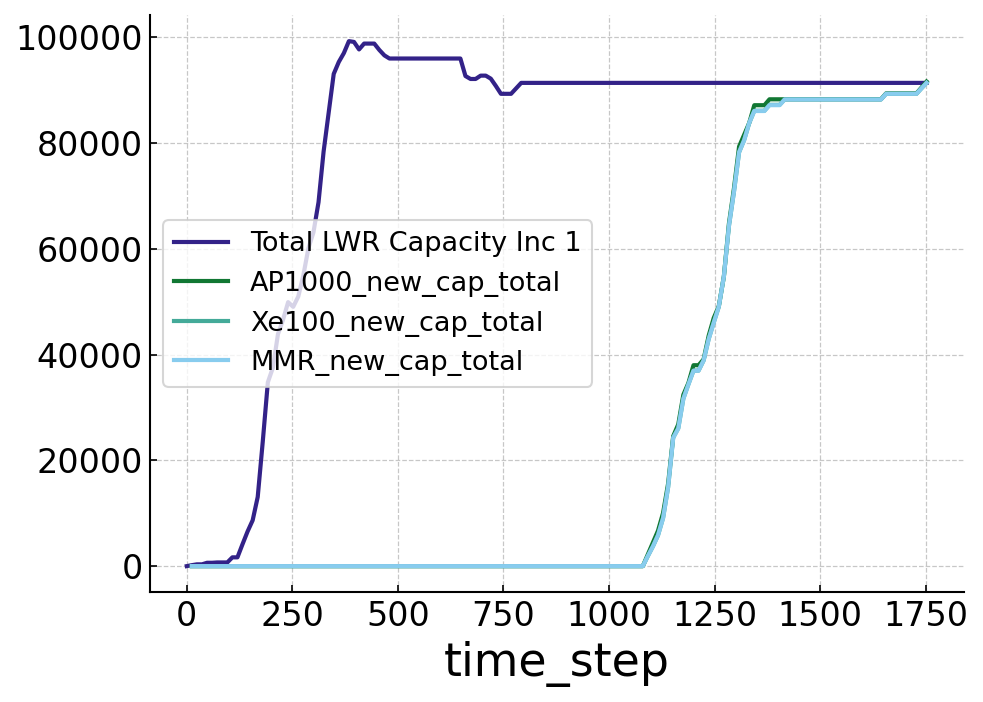

In [21]:
no_growth_cap_df[['time_step','Total LWR Capacity Inc 1','AP1000_new_cap_total', 'Xe100_new_cap_total', 'MMR_new_cap_total']].plot(x='time_step')

In [22]:
generate_deployinst_xml(no_growth_cap_df, 'AP1000')

'<DeployInst>\n               <prototypes>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</val>\n                  <val>AP1000</

In [24]:
output_dir = '../single_reactor/one_fuel/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(no_growth_cap_df, reactor)
    with open(f'{output_dir}ng_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Greedy

In [35]:
greedy_no_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_no_growth_cap_df, base_col='Total LWR Capacity', rate=1, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_no_growth_cap_df = greedy_no_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.greedy_deployment(df=greedy_no_growth_cap_df, base_col='New Capacity Inc 1', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year)

for reactor in sd.ad_reactors.keys():
    greedy_no_growth_cap_df[f'{reactor}_new'] = greedy_no_growth_cap_df[f'num_{reactor}']

greedy_no_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../greedy/ng/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_low_growth_cap_df, reactor)
    with open(f'{output_dir}ng_greedy_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Rand + Greedy

In [33]:
greedy_no_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_no_growth_cap_df, base_col='Total LWR Capacity', rate=1, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_no_growth_cap_df = greedy_no_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.rand_greedy_deployment(df=greedy_no_growth_cap_df, base_col='New Capacity Inc 1', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year, set_seed=True)

for reactor in sd.ad_reactors.keys():
    greedy_no_growth_cap_df[f'{reactor}_new'] = greedy_no_growth_cap_df[f'num_{reactor}']

greedy_no_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../rand_greed/ng/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_low_growth_cap_df, reactor)
    with open(f'{output_dir}ng_rand_greedy_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Random

In [53]:
greedy_no_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_no_growth_cap_df, base_col='Total LWR Capacity', rate=1, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_no_growth_cap_df = greedy_no_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.rand_deployment(df=greedy_no_growth_cap_df, base_col='New Capacity Inc 1', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year, set_seed=True)

for reactor in sd.ad_reactors.keys():
    greedy_no_growth_cap_df[f'{reactor}_new'] = greedy_no_growth_cap_df[f'num_{reactor}']

greedy_no_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../random/ng/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_low_growth_cap_df, reactor)
    with open(f'{output_dir}ng_random_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

# 1 % Growth

In [14]:
low_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=low_growth_cap_df, base_col='Total LWR Capacity', rate=1.01, start_year=sd.transition_year, end_year=sd.sim_end_yr)

for reactor in sd.ad_reactors.keys():
    low_growth_cap_df[f'{reactor}'] = np.ceil(low_growth_cap_df['New Capacity Inc 1.01']/sd.ad_reactors[reactor][0])

for reactor in sd.ad_reactors.keys():
    low_growth_cap_df[f'{reactor}_new'] = low_growth_cap_df[f'{reactor}'].diff()

In [17]:
output_dir = '../single_reactor/one_fuel/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(low_growth_cap_df, reactor)
    with open(f'{output_dir}lg_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Greedy

In [36]:
greedy_low_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_low_growth_cap_df, base_col='Total LWR Capacity', rate=1.01, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_low_growth_cap_df = greedy_low_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.greedy_deployment(df=greedy_low_growth_cap_df, base_col='New Capacity Inc 1.01', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year)

for reactor in sd.ad_reactors.keys():
    greedy_low_growth_cap_df[f'{reactor}_new'] = greedy_low_growth_cap_df[f'num_{reactor}']

greedy_low_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../greedy/one/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_low_growth_cap_df, reactor)
    with open(f'{output_dir}lg_greedy_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Rand + Greedy

In [32]:
greedy_low_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_low_growth_cap_df, base_col='Total LWR Capacity', rate=1.01, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_low_growth_cap_df = greedy_low_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.rand_greedy_deployment(df=greedy_low_growth_cap_df, base_col='New Capacity Inc 1.01', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year, set_seed=True)

for reactor in sd.ad_reactors.keys():
    greedy_low_growth_cap_df[f'{reactor}_new'] = greedy_low_growth_cap_df[f'num_{reactor}']

greedy_low_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../rand_greed/one/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_low_growth_cap_df, reactor)
    with open(f'{output_dir}lg_rand_greedy_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Random

In [52]:
greedy_low_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_low_growth_cap_df, base_col='Total LWR Capacity', rate=1.01, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_low_growth_cap_df = greedy_low_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.rand_deployment(df=greedy_low_growth_cap_df, base_col='New Capacity Inc 1.01', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year, set_seed=True)

for reactor in sd.ad_reactors.keys():
    greedy_low_growth_cap_df[f'{reactor}_new'] = greedy_low_growth_cap_df[f'num_{reactor}']

greedy_low_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../random/one/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_low_growth_cap_df, reactor)
    with open(f'{output_dir}lg_random_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

# 5% Growth by 2050

In [50]:
rate = 1.05**(1/(2050-2022))
print(f"Rate of growth: {rate}")

Rate of growth: 1.0017440249087228


In [19]:
med_5_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=med_5_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

for reactor in sd.ad_reactors.keys():
    med_5_growth_cap_df[f'{reactor}'] = np.ceil(med_5_growth_cap_df[f'New Capacity Inc {rate}']/sd.ad_reactors[reactor][0])

for reactor in sd.ad_reactors.keys():
    med_5_growth_cap_df[f'{reactor}_new'] = med_5_growth_cap_df[f'{reactor}'].diff()

In [22]:
output_dir = '../single_reactor/one_fuel/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(med_5_growth_cap_df, reactor)
    with open(f'{output_dir}m5g_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Greedy

In [39]:
greedy_mg5_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_mg5_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_mg5_growth_cap_df = greedy_mg5_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.greedy_deployment(df=greedy_mg5_growth_cap_df, base_col='New Capacity Inc 1.0017440249087228', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year)

for reactor in sd.ad_reactors.keys():
    greedy_mg5_growth_cap_df[f'{reactor}_new'] = greedy_mg5_growth_cap_df[f'num_{reactor}']

greedy_mg5_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../greedy/five/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_mg5_growth_cap_df, reactor)
    with open(f'{output_dir}mg5_greedy_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Rand + Greedy

In [31]:
greedy_mg5_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_mg5_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_mg5_growth_cap_df = greedy_mg5_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.rand_greedy_deployment(df=greedy_mg5_growth_cap_df, base_col='New Capacity Inc 1.0017440249087228', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year)

for reactor in sd.ad_reactors.keys():
    greedy_mg5_growth_cap_df[f'{reactor}_new'] = greedy_mg5_growth_cap_df[f'num_{reactor}']

greedy_mg5_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../rand_greed/five/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_mg5_growth_cap_df, reactor)
    with open(f'{output_dir}mg5_rand_greedy_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Random

In [51]:
greedy_mg5_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_mg5_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_mg5_growth_cap_df = greedy_mg5_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.rand_deployment(df=greedy_mg5_growth_cap_df, base_col='New Capacity Inc 1.0017440249087228', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year)

for reactor in sd.ad_reactors.keys():
    greedy_mg5_growth_cap_df[f'{reactor}_new'] = greedy_mg5_growth_cap_df[f'num_{reactor}']

greedy_mg5_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../random/five/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_mg5_growth_cap_df, reactor)
    with open(f'{output_dir}mg5_random_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

# 15% Growth by 2050

In [48]:
rate = 1.15**(1/(2050-2022))
print(f"Rate of growth: {rate}")

Rate of growth: 1.0050039762209513


In [24]:
med_15_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=med_15_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

for reactor in sd.ad_reactors.keys():
    med_15_growth_cap_df[f'{reactor}'] = np.ceil(med_15_growth_cap_df[f'New Capacity Inc {rate}']/sd.ad_reactors[reactor][0])

for reactor in sd.ad_reactors.keys():
    med_15_growth_cap_df[f'{reactor}_new'] = med_15_growth_cap_df[f'{reactor}'].diff()

,new_LWR_Capacity,Total LWR Capacity,time_step,Total LWR Capacity Inc 1.0050039762209513,New Capacity Inc 1.0050039762209513,AP1000,Xe100,MMR,AP1000_new,Xe100_new,MMR_new
1958,0.000,0.000000e+00,0,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN
1959,182.225,1.822250e+02,12,182.225000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1960,154.475,3.367000e+02,24,336.700000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1961,0.000,3.367000e+02,36,336.700000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1962,296.000,6.327000e+02,48,632.700000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2100,0.000,2.066450e+03,1704,130196.711108,128130.261108,115.0,1602.0,25627.0,0.0,8.0,130.0
2101,0.000,2.066450e+03,1716,130848.212355,128781.762355,116.0,1610.0,25757.0,1.0,8.0,130.0
2102,0.000,2.066450e+03,1728,131502.973698,129436.523698,116.0,1618.0,25888.0,0.0,8.0,131.0
2103,-1033.225,1.033225e+03,1740,132161.011451,131127.786451,118.0,1640.0,26226.0,2.0,22.0,338.0


In [26]:
output_dir = '../single_reactor/one_fuel/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(med_15_growth_cap_df, reactor)
    with open(f'{output_dir}m15g_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Greedy

In [41]:
greedy_mg15_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_mg15_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_mg15_growth_cap_df = greedy_mg15_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.greedy_deployment(df=greedy_mg15_growth_cap_df, base_col='New Capacity Inc 1.0050039762209513', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year)

for reactor in sd.ad_reactors.keys():
    greedy_mg15_growth_cap_df[f'{reactor}_new'] = greedy_mg15_growth_cap_df[f'num_{reactor}']

greedy_mg15_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../greedy/fifteen/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_mg15_growth_cap_df, reactor)
    with open(f'{output_dir}mg15_greedy_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Rand + Greedy

In [25]:
greedy_mg15_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_mg15_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_mg15_growth_cap_df = greedy_mg15_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.rand_greedy_deployment(df=greedy_mg15_growth_cap_df, base_col='New Capacity Inc 1.0050039762209513', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year, set_seed=True)

for reactor in sd.ad_reactors.keys():
    greedy_mg15_growth_cap_df[f'{reactor}_new'] = greedy_mg15_growth_cap_df[f'num_{reactor}']

greedy_mg15_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../rand_greed/fifteen/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_mg15_growth_cap_df, reactor)
    with open(f'{output_dir}mg15_rand_greedy_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Random

In [49]:
greedy_mg15_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_mg15_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_mg15_growth_cap_df = greedy_mg15_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.rand_deployment(df=greedy_mg15_growth_cap_df, base_col='New Capacity Inc 1.0050039762209513', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year, set_seed=True)

for reactor in sd.ad_reactors.keys():
    greedy_mg15_growth_cap_df[f'{reactor}_new'] = greedy_mg15_growth_cap_df[f'num_{reactor}']

greedy_mg15_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../random/fifteen/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_mg15_growth_cap_df, reactor)
    with open(f'{output_dir}mg15_random_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

# Double by 2050 starting in 2030

In [45]:
rate = 2**(1/(2050-2030))
print(f"Rate of growth: {rate}")

Rate of growth: 1.0352649238413776


In [46]:
d_2_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=d_2_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

for reactor in sd.ad_reactors.keys():
    d_2_growth_cap_df[f'{reactor}'] = np.ceil(d_2_growth_cap_df[f'New Capacity Inc {rate}']/sd.ad_reactors[reactor][0])

for reactor in sd.ad_reactors.keys():
    d_2_growth_cap_df[f'{reactor}_new'] = d_2_growth_cap_df[f'{reactor}'].diff()

In [37]:
output_dir = '../single_reactor/one_fuel/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(d_2_growth_cap_df, reactor)
    with open(f'{output_dir}d2g_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Greedy

In [43]:
greedy_dg2_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_dg2_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_dg2_growth_cap_df = greedy_dg2_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.greedy_deployment(df=greedy_dg2_growth_cap_df, base_col='New Capacity Inc 1.0352649238413776', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year)

for reactor in sd.ad_reactors.keys():
    greedy_dg2_growth_cap_df[f'{reactor}_new'] = greedy_dg2_growth_cap_df[f'num_{reactor}']

greedy_dg2_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../greedy/double/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_dg2_growth_cap_df, reactor)
    with open(f'{output_dir}dg2_greedy_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Rand + Greedy

In [27]:
greedy_dg2_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_dg2_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_dg2_growth_cap_df = greedy_dg2_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.rand_greedy_deployment(df=greedy_dg2_growth_cap_df, base_col='New Capacity Inc 1.0352649238413776', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year, set_seed=True)

for reactor in sd.ad_reactors.keys():
    greedy_dg2_growth_cap_df[f'{reactor}_new'] = greedy_dg2_growth_cap_df[f'num_{reactor}']

greedy_dg2_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../rand_greed/double/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_dg2_growth_cap_df, reactor)
    with open(f'{output_dir}dg2_rand_greedy_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Random

In [47]:
greedy_dg2_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_dg2_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_dg2_growth_cap_df = greedy_dg2_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.rand_deployment(df=greedy_dg2_growth_cap_df, base_col='New Capacity Inc 1.0352649238413776', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year, set_seed=True)

for reactor in sd.ad_reactors.keys():
    greedy_dg2_growth_cap_df[f'{reactor}_new'] = greedy_dg2_growth_cap_df[f'num_{reactor}']

greedy_dg2_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../random/double/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_dg2_growth_cap_df, reactor)
    with open(f'{output_dir}dg2_random_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

# Triple by 2050 from 2030

In [42]:
rate = 3**(1/(2050-2030))
print(f"Rate of growth: {rate}")

Rate of growth: 1.056467308549538


In [39]:
d_3_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=d_3_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

for reactor in sd.ad_reactors.keys():
    d_3_growth_cap_df[f'{reactor}'] = np.ceil(d_3_growth_cap_df[f'New Capacity Inc {rate}']/sd.ad_reactors[reactor][0])

for reactor in sd.ad_reactors.keys():
    d_3_growth_cap_df[f'{reactor}_new'] = d_3_growth_cap_df[f'{reactor}'].diff()

,new_LWR_Capacity,Total LWR Capacity,time_step,Total LWR Capacity Inc 1.056467308549538,New Capacity Inc 1.056467308549538,AP1000,Xe100,MMR,AP1000_new,Xe100_new,MMR_new
1958,0.000,0.000000e+00,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,NaN,NaN,NaN
1959,182.225,1.822250e+02,12,1.822250e+02,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
1960,154.475,3.367000e+02,24,3.367000e+02,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
1961,0.000,3.367000e+02,36,3.367000e+02,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
1962,296.000,6.327000e+02,48,6.327000e+02,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2100,0.000,2.066450e+03,1704,4.513029e+06,4.510962e+06,4039.0,56388.0,902193.0,216.0,3016.0,48244.0
2101,0.000,2.066450e+03,1716,4.767867e+06,4.765801e+06,4267.0,59573.0,953161.0,228.0,3185.0,50968.0
2102,0.000,2.066450e+03,1728,5.037096e+06,5.035029e+06,4508.0,62938.0,1007006.0,241.0,3365.0,53845.0
2103,-1033.225,1.033225e+03,1740,5.321527e+06,5.320494e+06,4764.0,66507.0,1064099.0,256.0,3569.0,57093.0


In [41]:
output_dir = '../single_reactor/one_fuel/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(d_3_growth_cap_df, reactor)
    with open(f'{output_dir}d3g_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Greedy

In [45]:
greedy_dg3_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_dg3_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_dg3_growth_cap_df = greedy_dg3_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.greedy_deployment(df=greedy_dg3_growth_cap_df, base_col='New Capacity Inc 1.056467308549538', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year)

for reactor in sd.ad_reactors.keys():
    greedy_dg3_growth_cap_df[f'{reactor}_new'] = greedy_dg3_growth_cap_df[f'num_{reactor}']

greedy_dg3_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../greedy/triple/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_dg3_growth_cap_df, reactor)
    with open(f'{output_dir}dg2_greedy_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Rand + Greedy

In [29]:
greedy_dg3_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_dg3_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_dg3_growth_cap_df = greedy_dg3_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.rand_greedy_deployment(df=greedy_dg3_growth_cap_df, base_col='New Capacity Inc 1.056467308549538', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year, set_seed=True)

for reactor in sd.ad_reactors.keys():
    greedy_dg3_growth_cap_df[f'{reactor}_new'] = greedy_dg3_growth_cap_df[f'num_{reactor}']

greedy_dg3_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../rand_greed/triple/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_dg3_growth_cap_df, reactor)
    with open(f'{output_dir}dg2_rand_greedy_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

## Random

In [43]:
greedy_dg3_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=greedy_dg3_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

# Make a column for the year.
greedy_dg3_growth_cap_df = greedy_dg3_growth_cap_df.reset_index().rename(columns={'index':'Year'})

dep.rand_deployment(df=greedy_dg3_growth_cap_df, base_col='New Capacity Inc 1.056467308549538', ar_dict=sd.ad_reactors, dep_start_year=sd.transition_year, set_seed=True)

for reactor in sd.ad_reactors.keys():
    greedy_dg3_growth_cap_df[f'{reactor}_new'] = greedy_dg3_growth_cap_df[f'num_{reactor}']

greedy_dg3_growth_cap_df.set_index('Year', inplace=True)

output_dir = '../random/triple/deployment_calcs/'
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_dg3_growth_cap_df, reactor)
    with open(f'{output_dir}dg2_random_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)